<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/Bitcoin_Price_and_its_Movement_Direction_Prediction_Ji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

# **Packages**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/BA_780/BA780 Team Project/bitcoin.csv") 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Modify Timestamp

In [6]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4857377 entries, 2011-12-31 07:52:00 to 2021-03-31 00:00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 296.5 MB


Spot the missing values

In [8]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


In [9]:
missed

,column,percent
0,Open,25.6
1,High,25.6
2,Low,25.6
3,Close,25.6
4,Volume_(BTC),25.6
5,Volume_(Currency),25.6
6,Weighted_Price,25.6


Fill in the missing data

In [10]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

In [11]:
df.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

Remove NA rows

In [12]:
df = df.dropna()

In [13]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [14]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

In [15]:
df["Price"]

Timestamp
2011-12-31 07:52:00        4.3900
2011-12-31 07:53:00        4.3900
2011-12-31 07:54:00        4.3900
2011-12-31 07:55:00        4.3900
2011-12-31 07:56:00        4.3900
                          ...    
2021-03-30 23:56:00    58700.1550
2021-03-30 23:57:00    58686.7950
2021-03-30 23:58:00    58708.6350
2021-03-30 23:59:00    58753.8325
2021-03-31 00:00:00    58770.0200
Name: Price, Length: 4857377, dtype: float64

In [16]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price
Timestamp,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39


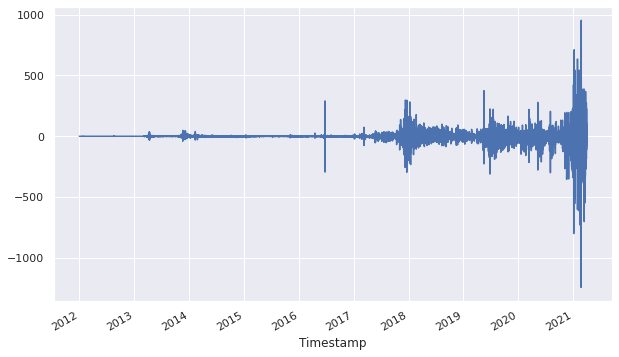

In [17]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [18]:
df['Return']

Timestamp
2011-12-31 07:52:00        NaN
2011-12-31 07:53:00     0.0000
2011-12-31 07:54:00     0.0000
2011-12-31 07:55:00     0.0000
2011-12-31 07:56:00     0.0000
                        ...   
2021-03-30 23:56:00   -28.0900
2021-03-30 23:57:00   -13.3600
2021-03-30 23:58:00    21.8400
2021-03-30 23:59:00    45.1975
2021-03-31 00:00:00    16.1875
Name: Return, Length: 4857377, dtype: float64

In [19]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] == 0), "Direction"] = "stable"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

In [20]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction
Timestamp,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,stable
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,stable
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,stable
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,stable


Add `Percentage_Return` column to show the perentage return per seconds

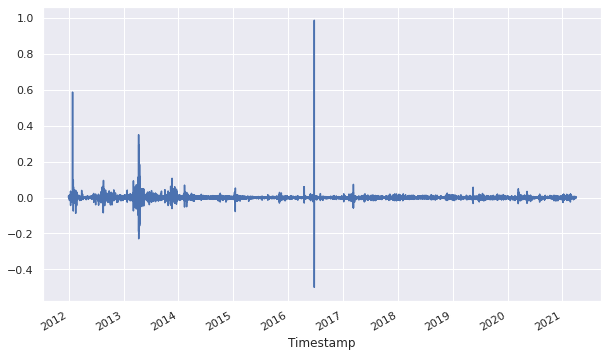

In [21]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df.head()
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [22]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return
Timestamp,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,stable,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,stable,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,stable,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,stable,0.0


In [22]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.head()
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:53:00,4.390,4.390,4.39,4.39,0.555046,2.436653,4.390000,4.3900,0.0000,stable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:54:00,4.390,4.390,4.39,4.39,0.654511,2.873305,4.390000,4.3900,0.0000,stable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:55:00,4.390,4.390,4.39,4.39,0.753977,3.309958,4.390000,4.3900,0.0000,stable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:56:00,4.390,4.390,4.39,4.39,0.853442,3.746611,4.390000,4.3900,0.0000,stable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:57:00,4.390,4.390,4.39,4.39,0.952907,4.183264,4.390000,4.3900,0.0000,stable,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:51:00,58677.050,58699.900,58660.00,58699.90,2.672676,156832.692130,58680.021260,58684.2125,2.8925,Up,0.000049,0.000234,0.000234,0.000545,-0.000263,-0.000478
2021-03-30 23:52:00,58697.865,58715.565,58679.17,58699.20,1.440329,84520.873706,58691.157958,58697.9500,13.7375,Up,0.000234,0.000234,0.000545,-0.000263,-0.000478,-0.000228
2021-03-30 23:53:00,58718.680,58731.230,58698.34,58698.50,0.207983,12209.055282,58702.294657,58711.6875,13.7375,Up,0.000234,0.000545,-0.000263,-0.000478,-0.000228,0.000372


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4857377 entries, 2011-12-31 07:52:00 to 2021-03-31 00:00:00
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
 7   Price              float64
 8   Return             float64
 9   Direction          object 
 10  Percentage_Return  float64
 11  Lag1               float64
 12  Lag2               float64
 13  Lag3               float64
 14  Lag4               float64
 15  Lag5               float64
dtypes: float64(15), object(1)
memory usage: 630.0+ MB


Cleaned Dataset Display

In [24]:
df.shape

(4857377, 16)

In [23]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return
Timestamp,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,stable,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,stable,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,stable,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,stable,0.0


#**Exploratory Data Analysis**

Zheming's Part

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

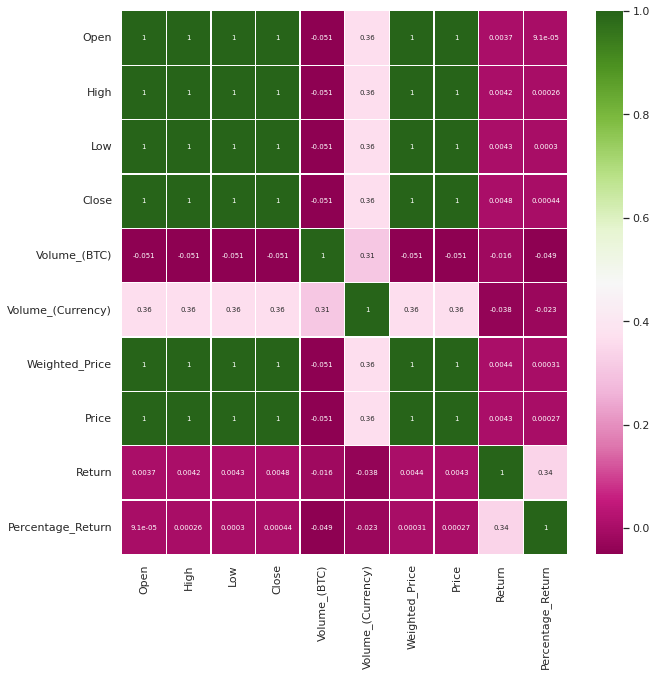

In [24]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [ ]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

In [25]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return
Timestamp,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,stable,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,stable,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,stable,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,stable,0.0


In [126]:
df_new = df[df.columns[:8]]

- Resampling timestamps and Plot price change over different unit of time 

In [127]:
# Resampling to half day frequency
df_D = df_new.resample('12H').mean()

# Resampling to weekly frequency
df_W = df_new.resample('W').mean()

# Resampling to quarterly frequency
df_month = df.resample('3M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

In [131]:
def fill_missing(df_D):
    ### function to impute missing values using interpolation ###
    df_D['Open'] = df_D['Open'].interpolate()
    df_D['Close'] = df_D['Close'].interpolate()
    df_D['High'] = df_D['High'].interpolate()
    df_D['Low'] = df_D['Low'].interpolate()
    df_D['Weighted_Price'] = df_D['Weighted_Price'].interpolate()
    df_D['Price'] = df_D['Price'].interpolate()
    df_D['Volume_(BTC)'] = df_D['Volume_(BTC)'].interpolate()
    df_D['Volume_(Currency)'] = df_D['Volume_(Currency)'].interpolate()

fill_missing(df_D)
fill_missing(df_W)
fill_missing(df_month)
fill_missing(df_year)

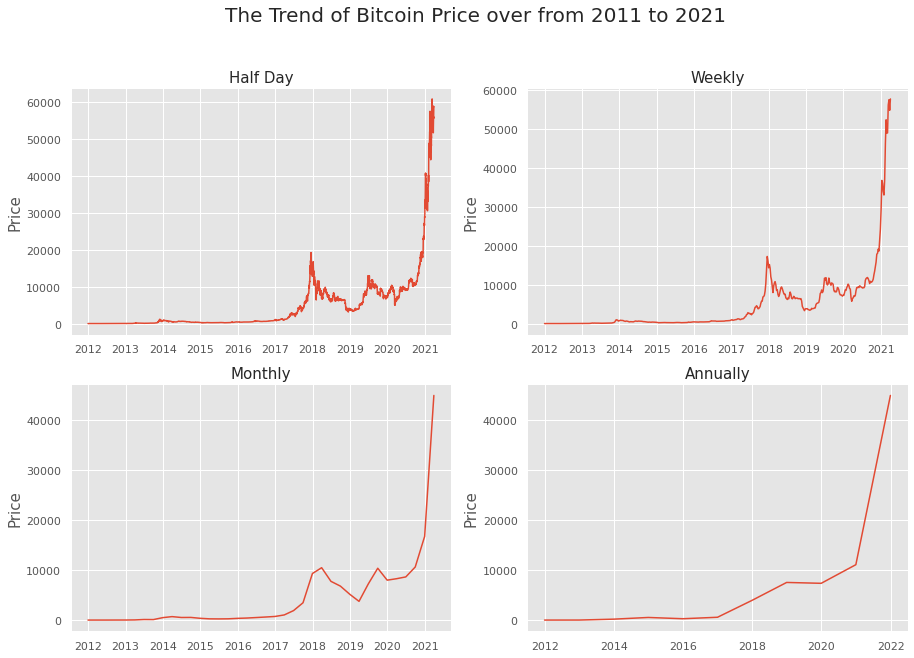

In [132]:
plt.style.use('ggplot')
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("The Trend of Bitcoin Price over from 2011 to 2021", va = 'center', size = 20)
ax[0][0].set_title("Half Day", fontsize = 15)
ax[0][1].set_title("Weekly", fontsize = 15)
ax[1][0].set_title("Monthly", fontsize = 15)
ax[1][1].set_title("Annually", fontsize = 15)

f1 = sns.lineplot(ax=ax[0][0], x = df_D.index, y = 'Price', data = df_D)
f1.set(xlabel='')
f1.set_ylabel('Price', fontsize = 15)
f2 = sns.lineplot(ax=ax[0][1], x = df_W.index, y = 'Price', data = df_W)
f2.set(xlabel='')
f2.set_ylabel('Price', fontsize = 15)
f3 = sns.lineplot(ax=ax[1][0], x = df_month.index, y = 'Price', data = df_month)
f3.set(xlabel='')
f3.set_ylabel('Price', fontsize = 15)
f4 = sns.lineplot(ax=ax[1][1], x = df_year.index, y = 'Price', data = df_year)
f4.set(xlabel='');
f4.set_ylabel('Price', fontsize = 15);

- From the above graphs, we can see that there was a steep price increase before 2018 followed by a rapid decline. In addition, the second peak occurred near the middle of 2019.

- It is much more accurate to detect the price change over a period of time, if we choose a smaller unit of time. For example, "Day" trend displays more information than "Year" trend.



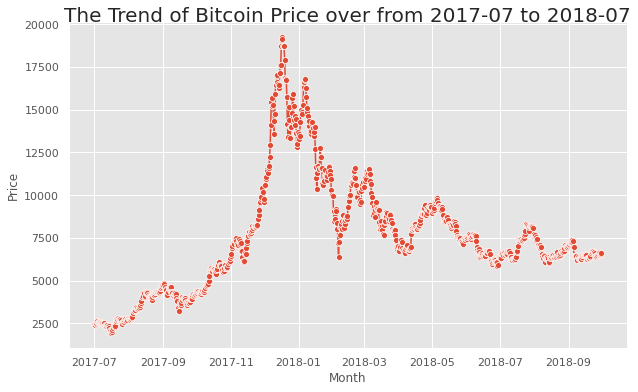

In [133]:
ax = sns.lineplot(y = df_D.loc['2017-07':'2018-09','Price'], x = df_D['2017-07':'2018-09'].index, marker='o', linestyle='-')
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.set_title("The Trend of Bitcoin Price over from 2017-07 to 2018-07", va = 'center', size = 20);

- When we zoom in on the above graph, it would be much more helpful for us to know the accurate trend of the price change. For example, there was a slump near the end of 2017 and a rapid increase at the beginning of 2018 which was ignored in the original graph.

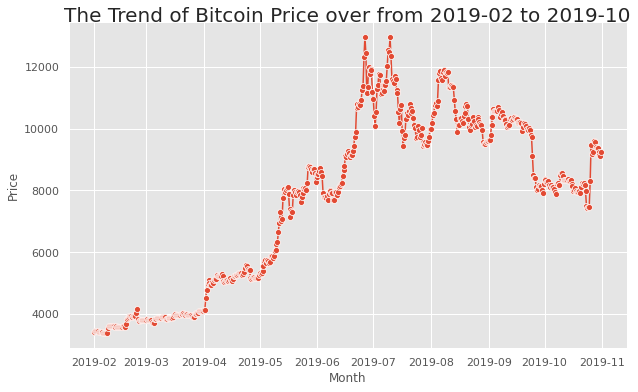

In [134]:
ax_1 = sns.lineplot(y = df_D.loc['2019-02':'2019-10','Price'], x = df_D['2019-02':'2019-10'].index, marker='o', linestyle='-')
ax_1.set_xlabel('Month')
ax_1.set_ylabel('Price')
ax_1.set_title("The Trend of Bitcoin Price over from 2019-02 to 2019-10", va = 'center', size = 20);

In [135]:
df_D.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6757 entries, 2011-12-31 00:00:00 to 2021-03-31 00:00:00
Freq: 12H
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6757 non-null   float64
 1   High               6757 non-null   float64
 2   Low                6757 non-null   float64
 3   Close              6757 non-null   float64
 4   Volume_(BTC)       6757 non-null   float64
 5   Volume_(Currency)  6757 non-null   float64
 6   Weighted_Price     6757 non-null   float64
 7   Price              6757 non-null   float64
dtypes: float64(8)
memory usage: 795.1 KB


In [269]:
df_D[df_D['year'] > 2016].groupby('month').Price.mean().sort_values(ascending = False)

month
Mar    14845.677018
Feb    13933.569778
Jan    12067.198229
Dec    11890.942336
Nov     9504.273731
Aug     8191.854790
Oct     7975.827819
Sep     7779.921215
Jul     7451.216032
Jun     7055.526904
May     6695.339822
Apr     5378.015854
Name: Price, dtype: float64

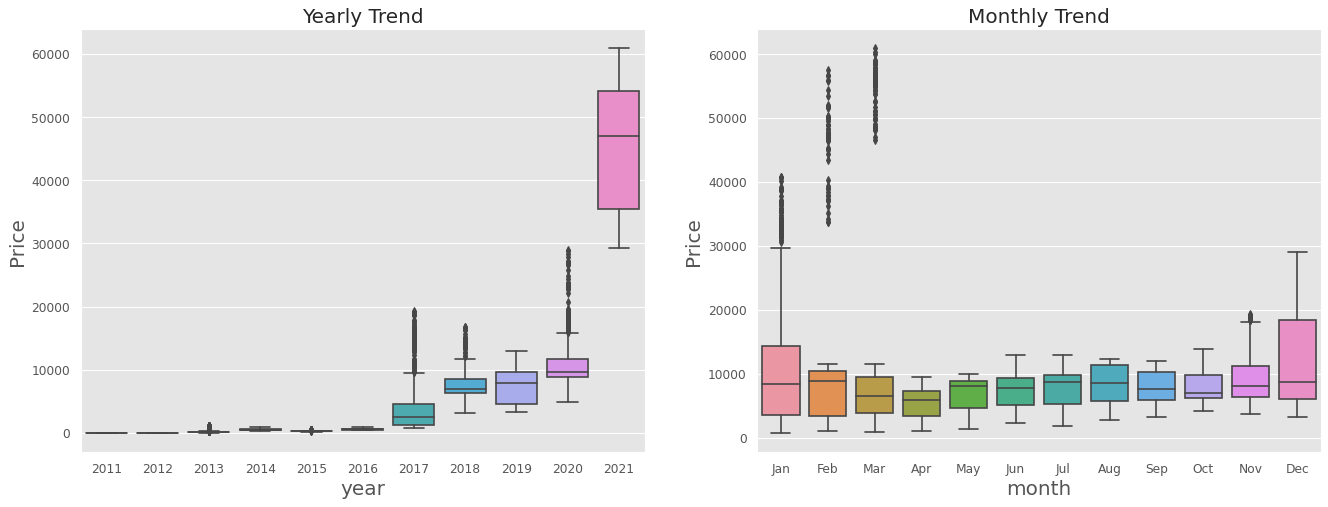

In [268]:
df_D['year'] = [d.year for d in df_D.index]
df_D['month'] = [d.strftime('%b') for d in df_D.index]
years = df_D['year'].unique()


fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=df_D, ax = axes[0])  
sns.boxplot(x='month', y='Price', data=df_D.loc[df_D.year.isin(list(range(2017,2022)))], ax= axes[1])


axes[0].set_title('Yearly Trend', fontsize=18); 
axes[1].set_title('Monthly Trend', fontsize=18);


- According to the above two boxplots, the left one shows the yearly trend of the bitcoins price, and we can see that from 2011 to 2016, the price almost had no change. Since 2017, the price started to increase and there was a rapid growth from 2020 to 2021. In addition, the maximum fluctutations in prices occurred in 2021.

- From the right plot, the highest mean value happened at the first quarter of the year and the lowest mean value appeared at the fourth quarter of each year. In addition, there were more outliers which was way higher than the mean values of each month appeared during the first quarter.

- Half Day Price Prediction Using Logistic Regression

In [136]:
df_D.loc[:, 'Next_Price'] = df_D['Price'].shift(-1)

df_D.loc[(df_D['Price'] > df_D['Next_Price']), 'Trend'] = 0
df_D.loc[(df_D['Price'] < df_D['Next_Price']), 'Trend'] = 1

df_D.drop(df.index[-1], axis=0, inplace=True) 

#df_D[['price_trend']] = df[['price_trend']].astype(int)

print(df_D.info())
df_D.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6756 entries, 2011-12-31 00:00:00 to 2021-03-30 12:00:00
Freq: 12H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6756 non-null   float64
 1   High               6756 non-null   float64
 2   Low                6756 non-null   float64
 3   Close              6756 non-null   float64
 4   Volume_(BTC)       6756 non-null   float64
 5   Volume_(Currency)  6756 non-null   float64
 6   Weighted_Price     6756 non-null   float64
 7   Price              6756 non-null   float64
 8   Next_Price         6756 non-null   float64
 9   Trend              6756 non-null   float64
dtypes: float64(10)
memory usage: 580.6 KB
None


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Next_Price,Trend
Timestamp,,,,,,,,,,
2011-12-31 00:00:00,4.390000,4.390000,4.390000,4.390000,12.739547,55.926611,4.390000,4.390000,4.507882,1.0
2011-12-31 12:00:00,4.506181,4.509583,4.506181,4.509583,19.731839,87.613799,4.507464,4.507882,4.637722,1.0
2012-01-01 00:00:00,4.637722,4.637722,4.637722,4.637722,3.895386,18.418087,4.637722,4.637722,4.893431,1.0
2012-01-01 12:00:00,4.893431,4.893431,4.893431,4.893431,9.685895,47.524124,4.893431,4.893431,5.000000,1.0
2012-01-02 00:00:00,5.000000,5.000000,5.000000,5.000000,13.139801,65.699007,5.000000,5.000000,5.013097,1.0


In [ ]:
# plt.style.use('classic')
# sns.pairplot(df_D, hue='Trend', height=2.5);

In [137]:
df_corr = df_D[list(df_D.columns[:6]) + list(df_D.columns[7:9])]

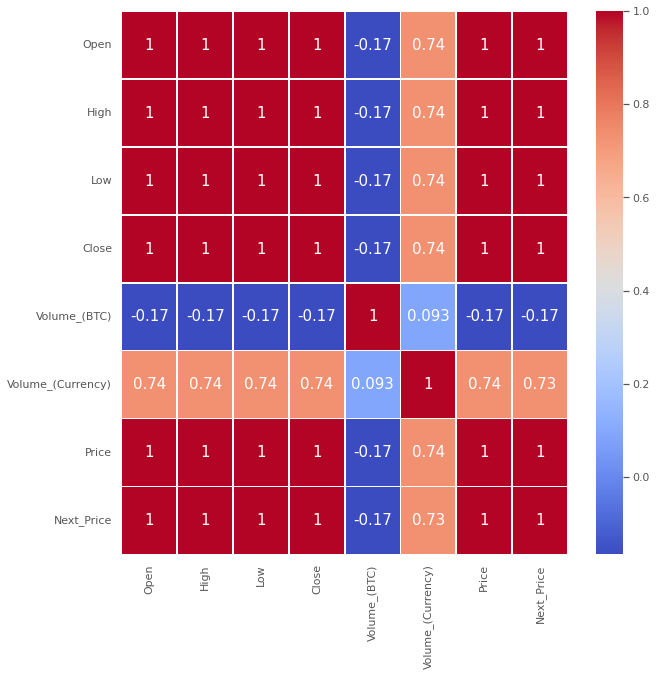

In [138]:
corr_heatmap = df_corr.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=15
sns.heatmap(corr_heatmap, cmap = 'coolwarm', annot = True, linewidths = 0.8)
#sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [158]:
# Predictor X
X = df_D.drop(["Trend", 'Volume_(BTC)', 'Weighted_Price','Next_Price'],  axis = 1)
X.shape

(6756, 6)

In [159]:
# Response y
y = df_D['Trend']
y.shape

(6756,)

In [160]:
# Split the text and train sets 
# Use a 20% split for test.
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=888)

In [161]:
len(Xtrain), len(Xtest), len(ytrain), len(ytest)

(5404, 1352, 5404, 1352)

In [162]:
from sklearn.linear_model import LogisticRegression   # choose model class
model = LogisticRegression(solver='liblinear')       # instantiate model

In [163]:
# Fit model to the training data:
model.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [164]:
# Predict the test set
y_model = model.predict(Xtest)

In [173]:
test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model, name = 'predicted trend')).sort_values('Timestamp').reset_index().drop('index', axis = 1)

,Timestamp,Open,High,Low,Close,Volume_(Currency),Price,Trend,predicted trend
0,2011-12-31 12:00:00,4.506181,4.509583,4.506181,4.509583,87.613799,4.507882,1.0,1.0
1,2012-01-01 00:00:00,4.637722,4.637722,4.637722,4.637722,18.418087,4.637722,1.0,1.0
2,2012-01-09 00:00:00,6.964578,6.964578,6.917682,6.917682,34.000604,6.941130,0.0,1.0
3,2012-01-10 00:00:00,6.288617,6.288617,6.288617,6.288617,12.598508,6.288617,1.0,1.0
4,2012-01-14 12:00:00,6.359557,6.359557,6.343395,6.343395,8.280054,6.351476,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1347,2021-03-22 12:00:00,56183.683319,56228.523264,56133.421514,56180.341861,387817.086917,56181.492490,0.0,0.0
1348,2021-03-25 00:00:00,52553.899500,52592.720049,52515.332875,52554.748104,183955.728220,52554.175132,0.0,1.0
1349,2021-03-26 12:00:00,53770.366264,53803.715736,53741.468667,53774.297583,195360.169663,53772.462063,1.0,1.0
1350,2021-03-28 12:00:00,55593.484910,55621.024493,55567.182479,55595.230937,95539.843663,55594.230705,1.0,1.0


In [167]:
# Check the accuracy of this model
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.5421597633136095

In [168]:
sum(y_model == ytest) / len(ytest)

0.5421597633136095

In [169]:
model.score(Xtest, ytest)

0.5421597633136095

- Our Logistic Regression model outputs the model accuracy at 54%

In [174]:
from sklearn.naive_bayes import GaussianNB
model_g = GaussianNB()
model_g.fit(Xtrain, ytrain)
y_model_g = model_g.predict(Xtest)


In [191]:
Xtest = Xtest.join(ytest, sort = True).reset_index()
Xtest.join(pd.Series(y_model_g, name = 'predicted_trend'))

,Timestamp,Open,High,Low,Close,Volume_(Currency),Price,Trend,predicted_trend
0,2011-12-31 12:00:00,4.506181,4.509583,4.506181,4.509583,87.613799,4.507882,1.0,1.0
1,2012-01-01 00:00:00,4.637722,4.637722,4.637722,4.637722,18.418087,4.637722,1.0,1.0
2,2012-01-09 00:00:00,6.964578,6.964578,6.917682,6.917682,34.000604,6.941130,0.0,1.0
3,2012-01-10 00:00:00,6.288617,6.288617,6.288617,6.288617,12.598508,6.288617,1.0,1.0
4,2012-01-14 12:00:00,6.359557,6.359557,6.343395,6.343395,8.280054,6.351476,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1347,2021-03-22 12:00:00,56183.683319,56228.523264,56133.421514,56180.341861,387817.086917,56181.492490,0.0,1.0
1348,2021-03-25 00:00:00,52553.899500,52592.720049,52515.332875,52554.748104,183955.728220,52554.175132,0.0,1.0
1349,2021-03-26 12:00:00,53770.366264,53803.715736,53741.468667,53774.297583,195360.169663,53772.462063,1.0,1.0
1350,2021-03-28 12:00:00,55593.484910,55621.024493,55567.182479,55595.230937,95539.843663,55594.230705,1.0,1.0


In [201]:
sum(y_model_g == ytest) / len(ytest)

0.5318047337278107

- Our gaussian naive bayes model shows the model accuracy at 53%, which is slightly lower than the Logistic Regression model.

- However, these two models are not good enough to predict the bitcoins price, since they don't capture any other impacts such as, seasonality, trend, and intrinsic factors.

# **ARIMA Model**

Geech's part here

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm

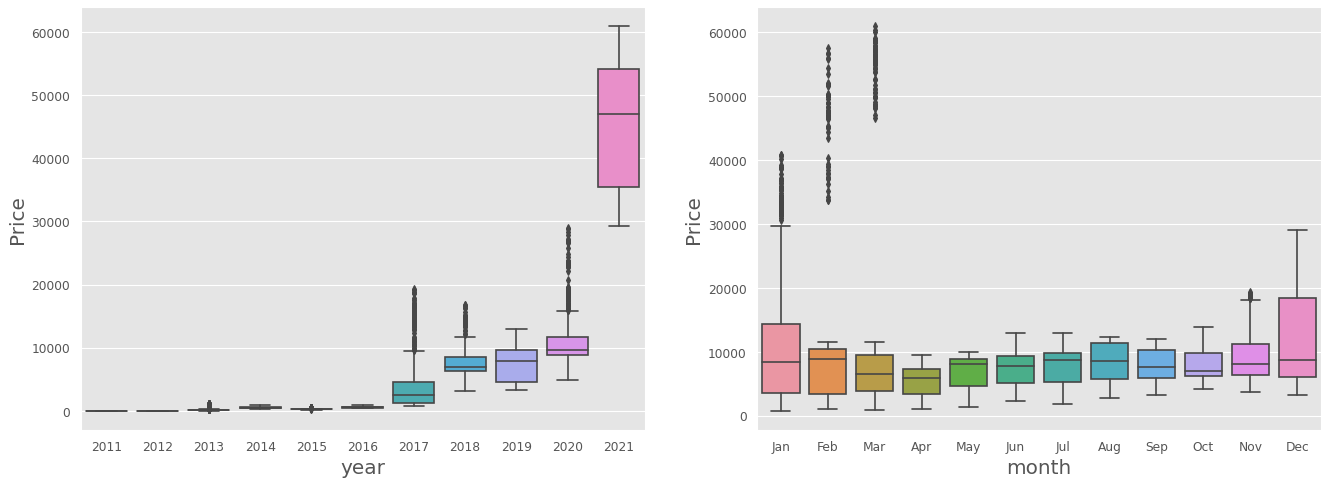